### Occlusion
- 두 이미지에서 동일한 object에 대해 매칭점을 찾을려고 하는데, 한 쪽 이미지에서 해당 이미지가 부분적으로 occlusion 돼 있는 경우

In [1]:
import numpy as np
import cv2
#Import necessary functions
from matplotlib import pyplot as plt
from planarH import computeH_ransac, computeH_norm 
from my_functions import compositeH_panorama, draw_matchings, panorama_stitching

In [6]:
img_dst = cv2.imread('../data/mod_Q15_desk_right.jpg')
img_src = cv2.imread('../data/Q15_desk_left.jpg')
img_dst = cv2.resize(img_dst, dsize=(int(img_dst.shape[1] * 0.6), int(img_dst.shape[0] * 0.6)), interpolation=cv2.INTER_AREA)
#img_src = cv2.resize(img_src, dsize=(int(img_src.shape[1] * 0.5), int(img_src.shape[0] * 0.5)), interpolation=cv2.INTER_AREA)
#resized_harry = cv2.resize(cv_harry, dsize=(cv_cover.shape[1], cv_cover.shape[0]), interpolation=cv2.INTER_AREA)


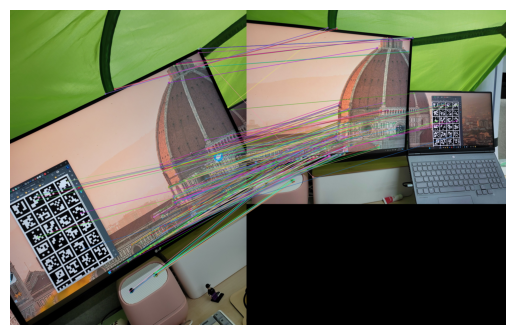

In [9]:
matching = draw_matchings(img_src, img_dst)
plt.imshow(cv2.cvtColor(matching, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

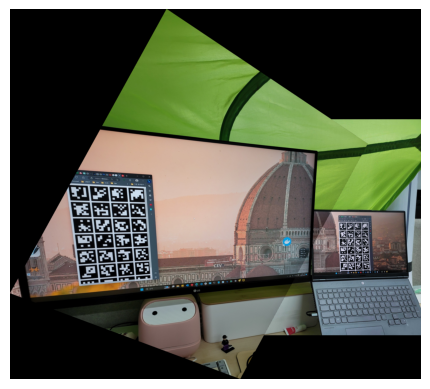

In [8]:
pano = panorama_stitching(img_src, img_dst)
plt.axis("off")
plt.imshow(cv2.cvtColor(pano, cv2.COLOR_BGR2RGB))

### keypoint masking

In [5]:
template_diagonal = int((img_src.shape[1]**2 + img_src.shape[0]**2)**(1/2))
img_dst_padded = cv2.copyMakeBorder(img_dst, top = template_diagonal, bottom= template_diagonal, left = template_diagonal, right = template_diagonal, borderType = 0)

orb = cv2.ORB_create(nfeatures=10000)

kp1, des1 = orb.detectAndCompute(img_src, None)
kp2, des2 = orb.detectAndCompute(img_dst, None)

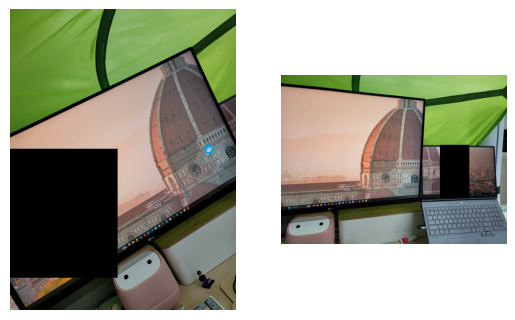

In [6]:
masked_img_src = img_src.copy()
masked_img_src[650:1250, 0:500] = 0

masked_img_dst = img_dst.copy()
masked_img_dst[600:1050, 1350:1600] = 0

fig = plt.figure()
f1 = fig.add_subplot(1,2,1)
f2 = fig.add_subplot(1,2,2)

f1.axis('off')
f2.axis('off')
f1.imshow(cv2.cvtColor(masked_img_src, cv2.COLOR_BGR2RGB))
f2.imshow(cv2.cvtColor(masked_img_dst, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
in_mirror_kp1 = []
in_mirror_kp2 = []

for i in range(len(kp1)):
    if (kp1[i].pt[1] > 650 and kp1[i].pt[1] < 1250) and (kp1[i].pt[0] > 0 and kp1[i].pt[0] < 500):
        in_mirror_kp1.append(i)

    else:
        pass
    
for j in range(len(kp2)):
    if (kp2[j].pt[1] > 600 and kp2[j].pt[1] < 1050) and (kp2[j].pt[0] > 1350 and kp2[j].pt[0] < 1600):
        in_mirror_kp2.append(j)

    else:
        pass

kp1_del = np.delete(kp1, in_mirror_kp1, axis = 0)
des1_del = np.delete(des1, in_mirror_kp1, axis = 0)

kp2_del = np.delete(kp2, in_mirror_kp2, axis = 0)
des2_del = np.delete(des2, in_mirror_kp2, axis = 0)

In [8]:
print("Masking keypoints")
print("kp1", len(kp1))
print("kp1_del", len(kp1_del))
print("kp2", len(kp2))
print("kp2_del", len(kp2_del))

print("des1.shape", des1.shape)
print("des1_del.shape", des1_del.shape)
print("des2.shape", des2.shape)
print("des2_del.shape", des2_del.shape)

Masking keypoints
kp1 10000
kp1_del 2872
kp2 10000
kp2_del 5149
des1.shape (10000, 32)
des1_del.shape (2872, 32)
des2.shape (10000, 32)
des2_del.shape (5149, 32)


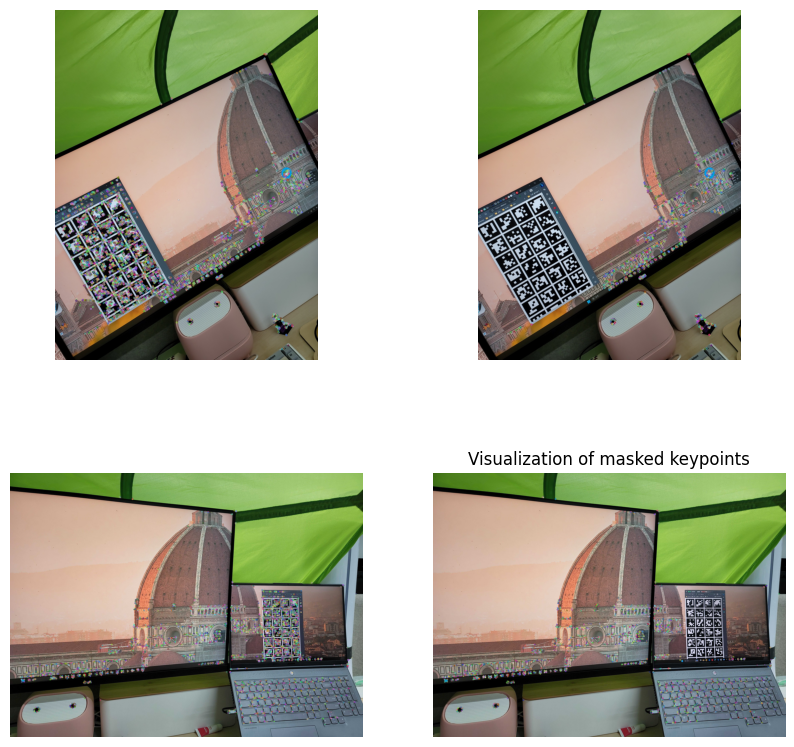

In [9]:
kp1_img = cv2.drawKeypoints(img_src, kp1, None)
kp1_del_img = cv2.drawKeypoints(img_src, kp1_del, None)

kp2_img = cv2.drawKeypoints(img_dst, kp2, None)
kp2_del_img = cv2.drawKeypoints(img_dst, kp2_del, None)

fig = plt.figure(figsize=(10,10))

f1 = fig.add_subplot(2,2,1)
f2 = fig.add_subplot(2,2,2)
f3 = fig.add_subplot(2,2,3)
f4 = fig.add_subplot(2,2,4)

f1.axis('off')
f2.axis('off')
f3.axis('off')
f4.axis('off')

f1.imshow(cv2.cvtColor(kp1_img, cv2.COLOR_BGR2RGB))
f2.imshow(cv2.cvtColor(kp1_del_img, cv2.COLOR_BGR2RGB))
f3.imshow(cv2.cvtColor(kp2_img, cv2.COLOR_BGR2RGB))
f4.imshow(cv2.cvtColor(kp2_del_img, cv2.COLOR_BGR2RGB))
plt.title('Visualization of masked keypoints')
plt.show()

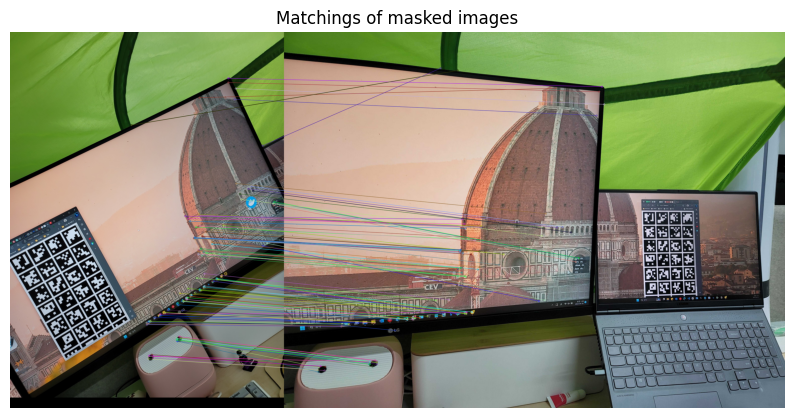

In [10]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_cv = bf.match(des1_del, des2_del)

# Sort matches by distance
matches_cv = sorted(matches_cv, key=lambda x: x.distance)

num_matches = int(len(matches_cv) * 0.1)  # choose 10% of total matches
best_matches = matches_cv[:num_matches]
img_matches = cv2.drawMatches(img_src, kp1_del, img_dst,  kp2_del, best_matches, None, flags=2)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Matchings of masked images')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show() 

In [11]:
template_diagonal = int((img_src.shape[1]**2 + img_src.shape[0]**2)**(1/2))
img_dst_padded = cv2.copyMakeBorder(img_dst, top = template_diagonal, bottom= template_diagonal, left = template_diagonal, right = template_diagonal, borderType = 0)

orb = cv2.ORB_create(nfeatures=10000)

kp1, des1 = orb.detectAndCompute(img_src, None)
kp2, des2 = orb.detectAndCompute(img_dst_padded, None)

In [12]:
in_mirror_kp1 = []
in_mirror_kp2 = []

for i in range(len(kp1)):
    if (kp1[i].pt[1] > 400 and kp1[i].pt[1] < 1000) and (kp1[i].pt[0] > 400 and kp1[i].pt[0] < 800):
        in_mirror_kp1.append(i)

    else:
        pass
    
for j in range(len(kp2)):
    if (kp2[j].pt[1] > 600 +template_diagonal and kp2[j].pt[1] < 1050+template_diagonal ) and (kp2[j].pt[0] > 1350+template_diagonal  and kp2[j].pt[0] < 1600+template_diagonal ):
        in_mirror_kp2.append(j)

    else:
        pass

kp1_del = np.delete(kp1, in_mirror_kp1, axis = 0)
des1_del = np.delete(des1, in_mirror_kp1, axis = 0)

kp2_del = np.delete(kp2, in_mirror_kp2, axis = 0)
des2_del = np.delete(des2, in_mirror_kp2, axis = 0)

In [13]:
print("kp1", len(kp1))
print("kp1_del", len(kp1_del))
print("kp2", len(kp2))
print("kp2_del", len(kp2_del))

print("des1.shape", des1.shape)
print("des1_del.shape", des1_del.shape)
print("des2.shape", des2.shape)
print("des2_del.shape", des2_del.shape)

kp1 10000
kp1_del 9139
kp2 10000
kp2_del 5157
des1.shape (10000, 32)
des1_del.shape (9139, 32)
des2.shape (10000, 32)
des2_del.shape (5157, 32)


In [14]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_cv = bf.match(des1_del, des2_del)

# Sort matches by distance
matches_cv = sorted(matches_cv, key=lambda x: x.distance)

# Select the top 10% accurate matches

num_matches = int(len(matches_cv) * 0.1)  # choose 10% of total matches
best_matches = matches_cv[:num_matches]

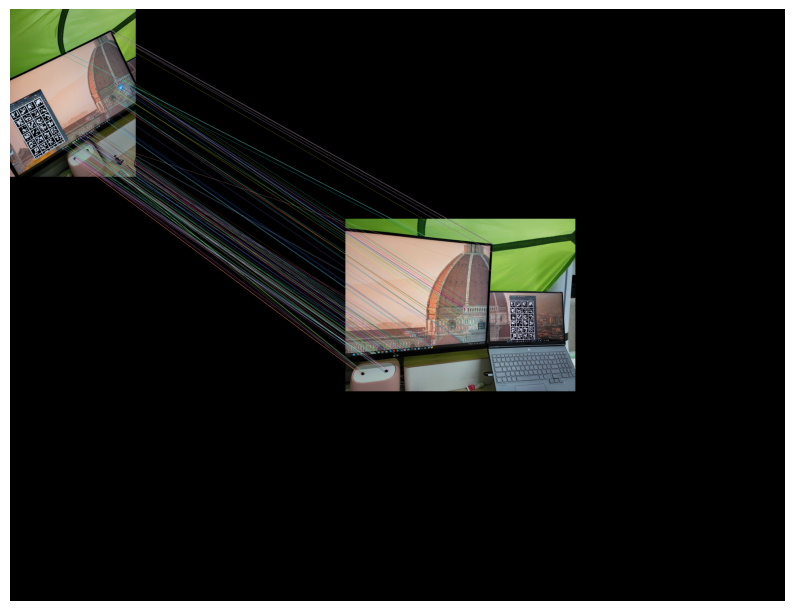

In [15]:
img_matches = cv2.drawMatches(img_src, kp1_del, img_dst_padded,  kp2_del, best_matches, None, flags=2)

# Display the image with matches
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show() 

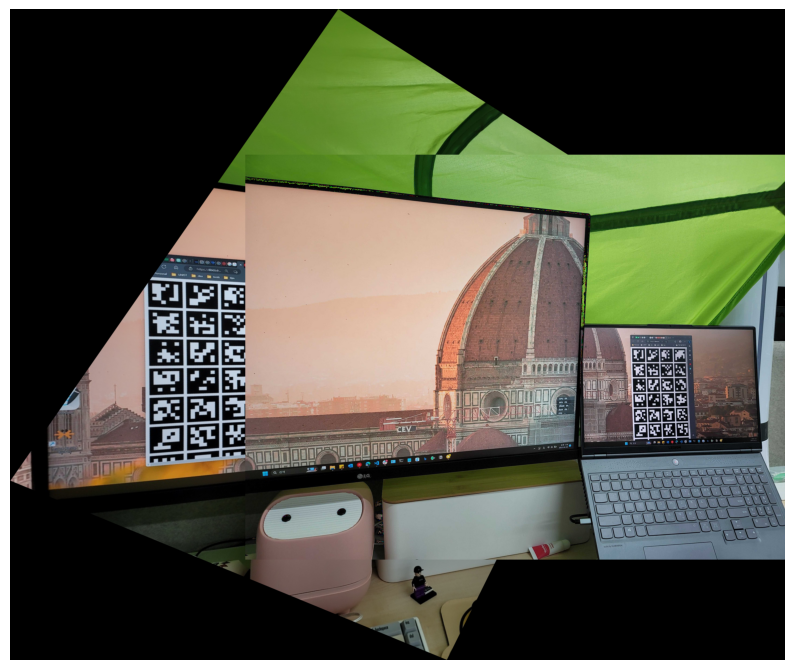

In [16]:
pts1_best = np.float32([kp1_del[m.queryIdx].pt for m in best_matches]).reshape(-1, 2)
pts2_best = np.float32([kp2_del[m.trainIdx].pt for m in best_matches]).reshape(-1, 2)

H2to1, inliers = computeH_ransac(pts2_best, pts1_best, 300, 2, adaptive = True)

H2to1 = computeH_norm(pts2_best[inliers], pts1_best[inliers])

panorama = compositeH_panorama(H2to1, img_dst, img_src)


plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()